# Module 4 Project
### Khairul Omar, Stuti Singh & Aleksandar Gavokic

# Executive summary

Insert executive summary here

# 1. Data import

In [1772]:
import pandas as pd
pd.set_option('display.max_rows', 540)
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from textwrap import wrap

import scipy.stats as stats

from sklearn.preprocessing import StandardScaler, scale, Normalizer, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error

from itertools import combinations

import statsmodels.api as sm
from statsmodels.formula.api import ols

In [1863]:
# Import raw data
raw = pd.read_csv('analytic_data2019.csv', skiprows=[1,2])
display(raw.shape)
display(raw.head())

(3193, 534)

,State FIPS Code,County FIPS Code,5-digit FIPS Code,State Abbreviation,Name,Release Year,County Ranked (Yes=1/No=0),Premature death raw value,Premature death numerator,Premature death denominator,...,Male population 18-44 raw value,Male population 45-64 raw value,Male population 65+ raw value,Total male population raw value,Female population 0-17 raw value,Female population 18-44 raw value,Female population 45-64 raw value,Female population 65+ raw value,Total female population raw value,Population growth raw value
0,1,0,1000,AL,Alabama,2019,NaN,9917.232898,80440.0,13636816.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,1001,AL,Autauga County,2019,1.0,8824.057123,815.0,156132.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,1003,AL,Baldwin County,2019,1.0,7224.632160,2827.0,576496.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,5,1005,AL,Barbour County,2019,1.0,9586.165037,451.0,72222.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,7,1007,AL,Bibb County,2019,1.0,11783.543675,445.0,63653.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2. Data Cleansing

In [1864]:
# Remove unnecessary columns
filter_out = ['numerator', 'denominator', 'CI low', 'CI high']
df = raw.copy()
for f in filter_out:
    df = df.loc[:, ~df.columns.str.contains(f)]

# Clean up column names
replace_dict = {' raw value':'', ' - ':'_', '-':'_', '=':'', '/':'_',
                '(':'', ')':'', '.':'', '+':' above', '%':'Percent', ' ':'_'}
for key, value in replace_dict.items():
    df.columns = df.columns.str.replace(key, value)

# Drop column if data is > 20% null
df = df.drop(df.loc[:,list((100*(df.isnull().sum()/len(df.index))>20))].columns, 1)

# Replace NaN values with the state's median. If missing, use national.
df = df.groupby('State_Abbreviation').apply(lambda x: x.fillna(x.median()))
df = df.fillna(df.median())

# Remove state-level data, keep only county-level data
df = df.drop(df[df.County_FIPS_Code==0].index)

# Keep a copy with all cleansed columns as df0
df = df.reset_index(drop=True)
df0 = df.copy()

# Basis of df to use for modelling
df = df.drop(df.iloc[:, 0:7], axis = 1) # skip columns 0-6 which are non-numerical

cols = list(df.columns)
display(df.shape)

(3142, 74)

# 3. Data Exploration (EDA)

### 3.1 Overview of data via plots

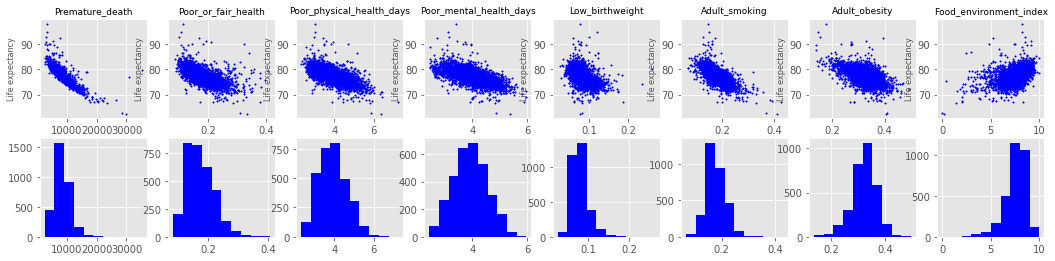

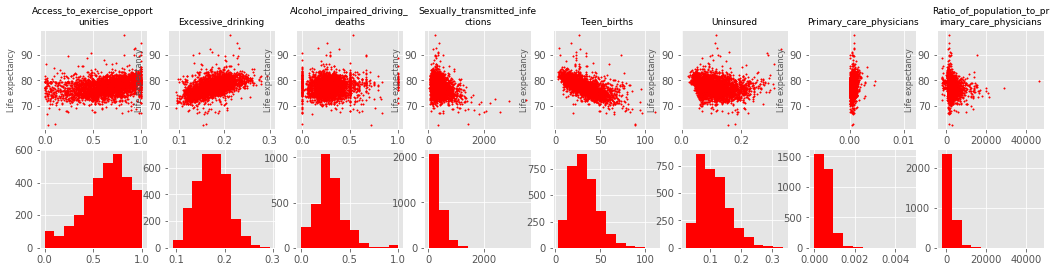

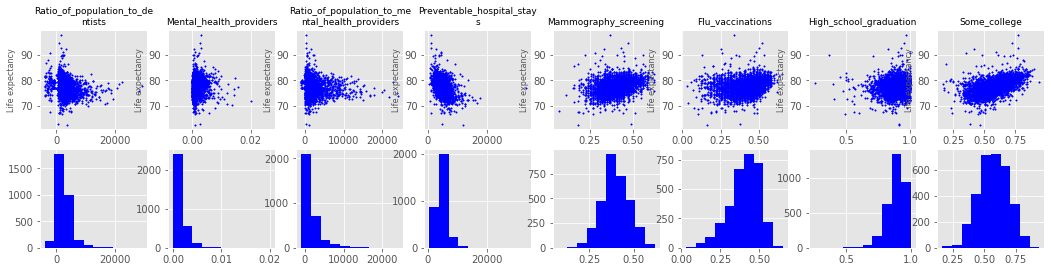

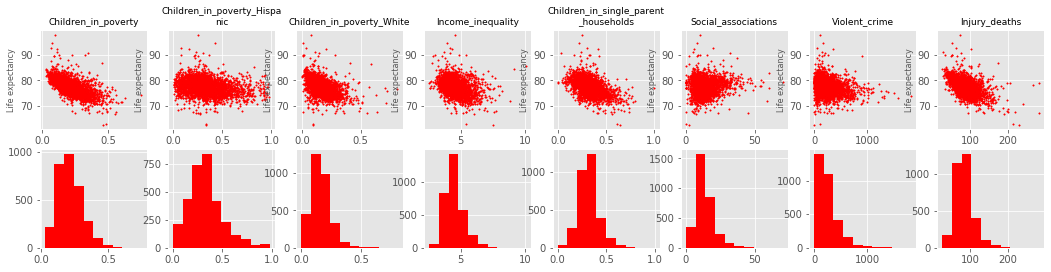

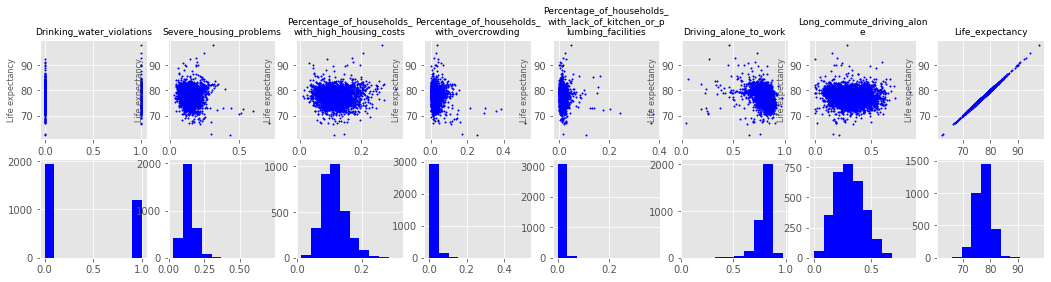

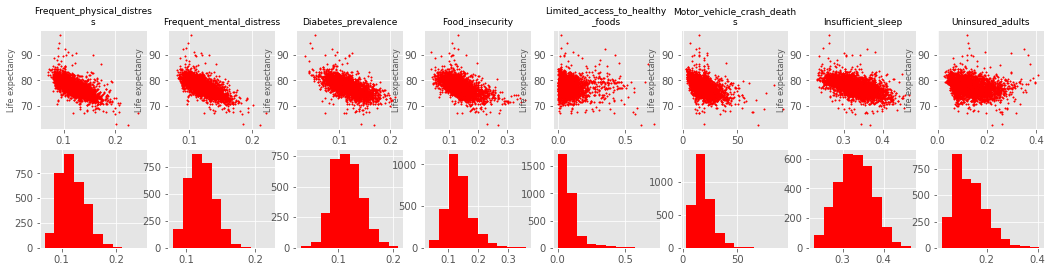

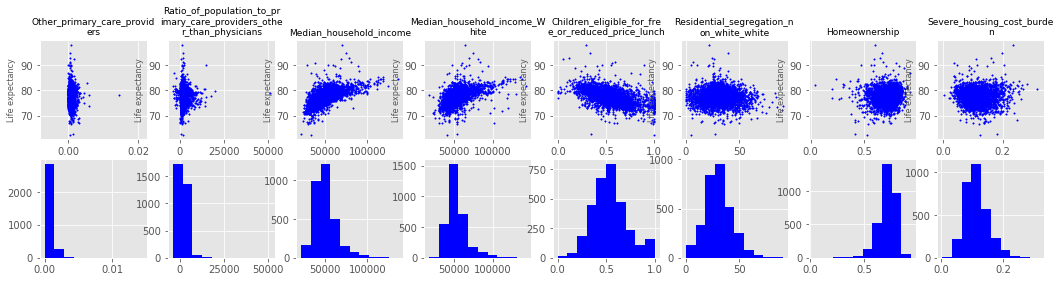

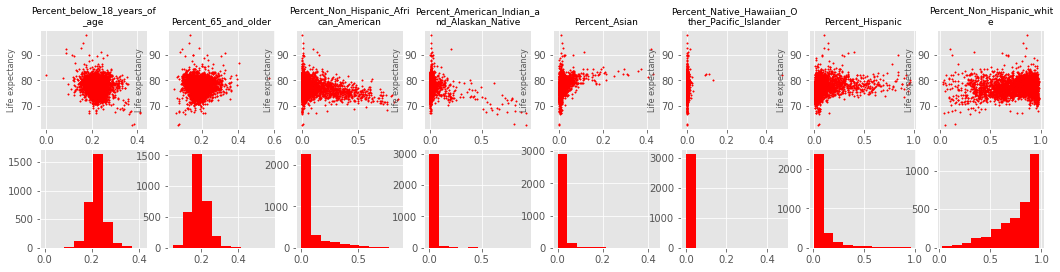

In [1681]:
# Plot all columns using scatter plot & histogram
num_of_cols = df.shape[1]
num_of_plots_per_row = 8
num_of_sets = num_of_cols // (num_of_plots_per_row + 1)
k = 0
for r, s in enumerate(range(num_of_sets)):
    color = 'blue' if (r % 2) == 0 else 'red'
    x1 = k
    x2 = k + num_of_plots_per_row
    k = k + num_of_plots_per_row + 1
    r = r * 2
    dfplot = df.iloc[:, x1:x2]
    cols_to_plot = list(dfplot.columns)

    fig, axes = plt.subplots(nrows=2, ncols=len(cols_to_plot), figsize=(18,4))
    for n, xcol in enumerate(cols_to_plot):
        axes[0,n].set_title("\n".join(wrap(xcol, 25)), fontsize=9)
        axes[0,n].scatter(dfplot[xcol], df.Life_expectancy, color=color, s=2)
        axes[0,n].set_ylabel('Life expectancy', fontsize=8)
        axes[1,n].hist(dfplot[xcol], color=color)       
    plt.show()

# 4. Feature Selection: Evaluate all predictors

### 4.1 Split training and test data

In [1865]:
y_all = df['Life_expectancy']
x_all = df.drop('Life_expectancy', axis=1)

# Split 80/20 for training/testing
x_train, x_test, y_train, y_test = train_test_split(scale(x_all), y_all, test_size=0.20, random_state=1)

# Training data
x = pd.DataFrame(x_train, columns=x_all.columns)
y = (pd.DataFrame(y_train)).reset_index(drop=True)
dftrain = pd.concat([y, x], axis=1)

### 4.1 Baseline (i) : calculate k-fold cv with all predictors

In [1866]:
# Cross validation using all columns

regression = LinearRegression()
crossvalidation = KFold(n_splits=5, shuffle=True, random_state=1)
baseline1 = np.mean(cross_val_score(regression, x, y, scoring='r2', cv=crossvalidation))

print(f'No of predictors: {x.shape[1]}')
print(f'CV r-sq: {baseline1}')

No of predictors: 73
CV r-sq: 0.8930229197769848


### 4.2 Evaluate predictors (i) : Correlation of predictors vs. target

In [1867]:
# Calculate correlation coeff with LIFE EXPECTENCY for all predictors
cols = list(dftrain.columns)
corr_list = []

for col in cols:    
    # Correlation with x    
    corr = stats.pearsonr(dftrain[col], dftrain.Life_expectancy)    
    # Correlation with log x
    transformer = Normalizer().fit([dftrain[col]])
    t = transformer.transform([dftrain[col]])   
    if dftrain[col].min() <= 0:
        corrlog = 0
    else:
        corrlog = stats.pearsonr(np.log(t[0]), dftrain.Life_expectancy)[0]
    # Output list
    corr_list.append([abs(round(corr[0],3)), abs(round(corrlog, 3)), col])

# Show sorted list of columns and correlations between life expectancy vs. column and log(column)
corr_list = sorted(corr_list, key=lambda x: x[0], reverse=True)
k = 20
print(f'Top {k} Correlation between all predictors (original & log transformed) vs. Life expectancy:')
display(corr_list[0:20])

Top 20 Correlation between all predictors (original & log transformed) vs. Life expectancy:


[[1.0, 0.999, 'Life_expectancy'],
 [0.936, 0, 'Premature_age_adjusted_mortality'],
 [0.89, 0, 'Premature_death'],
 [0.695, 0, 'Adult_smoking'],
 [0.691, 0, 'Frequent_mental_distress'],
 [0.672, 0, 'Frequent_physical_distress'],
 [0.666, 0, 'Poor_physical_health_days'],
 [0.662, 0, 'Teen_births'],
 [0.648, 0, 'Children_in_poverty'],
 [0.646, 0, 'Diabetes_prevalence'],
 [0.632, 0, 'Poor_or_fair_health'],
 [0.632, 0, 'Poor_mental_health_days'],
 [0.622, 0, 'Median_household_income'],
 [0.621, 0, 'Physical_inactivity'],
 [0.606, 0, 'Food_insecurity'],
 [0.544, 0, 'Excessive_drinking'],
 [0.544, 0, 'Children_eligible_for_free_or_reduced_price_lunch'],
 [0.536, 0, 'Adult_obesity'],
 [0.534, 0, 'Some_college'],
 [0.532, 0, 'Insufficient_sleep']]

In [1868]:
# Top strongest correlation with LIFE EXPECTANCY, removing the first 3 which are not relevant:
top_n = 15
ignore_from = 3
top_predictors = list(map(lambda x: x[2], corr_list[ignore_from:ignore_from+top_n]))
print(f'Top {top_n} strongest linear correlation with Life Expectancy:')
display(top_predictors)

Top 15 strongest linear correlation with Life Expectancy:


['Adult_smoking',
 'Frequent_mental_distress',
 'Frequent_physical_distress',
 'Poor_physical_health_days',
 'Teen_births',
 'Children_in_poverty',
 'Diabetes_prevalence',
 'Poor_or_fair_health',
 'Poor_mental_health_days',
 'Median_household_income',
 'Physical_inactivity',
 'Food_insecurity',
 'Excessive_drinking',
 'Children_eligible_for_free_or_reduced_price_lunch',
 'Adult_obesity']

### 4.3 Evaluate predictors (ii) : Multicollinearity between all predictors

In [1869]:
# Check correlation between ALL columns - to avoid multicollinearity
combo1 = list(combinations(top_predictors, 2))
corr_list1 = []
for comb in combo1:
    corr = stats.pearsonr(dftrain[comb[0]], dftrain[comb[1]])
    corr_list1.append([abs(round(corr[0],3)), comb[0], comb[1]])  
    
# Show sorted list of columns and correlations between life expectancy vs. column and log(column)
corr_list1 = sorted(corr_list1, key=lambda x: x[0], reverse=True)
print('Correlation between predictors to avoid multicollinearity (0.8 cut-off):')
display(list(filter(lambda x: x[0] > 0.8, corr_list1)))

Correlation between predictors to avoid multicollinearity (0.8 cut-off):


[[0.982, 'Frequent_physical_distress', 'Poor_physical_health_days'],
 [0.955, 'Frequent_mental_distress', 'Frequent_physical_distress'],
 [0.954, 'Frequent_mental_distress', 'Poor_physical_health_days'],
 [0.953, 'Frequent_mental_distress', 'Poor_mental_health_days'],
 [0.93, 'Frequent_physical_distress', 'Poor_or_fair_health'],
 [0.919, 'Poor_physical_health_days', 'Poor_mental_health_days'],
 [0.88, 'Poor_physical_health_days', 'Poor_or_fair_health'],
 [0.876, 'Frequent_physical_distress', 'Poor_mental_health_days'],
 [0.844, 'Frequent_mental_distress', 'Poor_or_fair_health'],
 [0.833, 'Children_in_poverty', 'Poor_or_fair_health'],
 [0.824, 'Adult_smoking', 'Frequent_mental_distress'],
 [0.818, 'Adult_smoking', 'Frequent_physical_distress'],
 [0.817, 'Frequent_physical_distress', 'Children_in_poverty'],
 [0.809, 'Adult_smoking', 'Poor_physical_health_days']]

In [1870]:
# Drop top predictors based on multicollinearity etc:

drop_list = ['Frequent_mental_distress', 'Frequent_physical_distress', 'Poor_physical_health_days',
             'Children_eligible_for_free_or_reduced_price_lunch']

top_predictors = [x for x in top_predictors if x not in drop_list]
len(top_predictors)

11

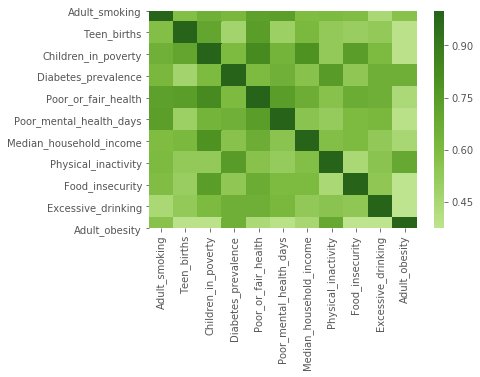

In [1871]:
# Validate via correlation heatmap between top predictors after drop:
sns.heatmap(abs(df[top_predictors[:]].corr()), cmap="PiYG", center=0)
plt.show()

### 4.4 Baseline (ii) : calculate with top predictors

In [1872]:
# Cross validation using top predictors
x = x[top_predictors[:]]

regression = LinearRegression()
crossvalidation = KFold(n_splits=5, shuffle=True, random_state=1)
baseline2 = np.mean(cross_val_score(regression, x, y, scoring='r2', cv=crossvalidation))

print(f'No of predictors: {x.shape[1]}')
print(f'CV r-sq: {baseline2}')

No of predictors: 11
CV r-sq: 0.6582108796214635


### 4.5 Evaluate predictors (iii) : Interaction between top predictors

In [1873]:
# Check interactions of top predictors pairs

regression = LinearRegression()
crossvalidation = KFold(n_splits=5, shuffle=True, random_state=1)
combo2 = list(combinations(x.columns, 2))

interactions = []
data = pd.DataFrame(scale(x), columns=x.columns)
for comb in combo2:
    data['interaction'] = data[comb[0]] * data[comb[1]]
    score = np.mean(cross_val_score(regression, data, y, scoring='r2', cv=crossvalidation))
    if score > baseline2: interactions.append((round(score, 3), comb[0], comb[1]))

interactions = sorted(interactions, key=lambda x: x[0], reverse=True)

k = 20
print(f'Max value of r2: {max(interactions)[0]}')
print(f'Min value of r2: {min(interactions)[0]}')
print(f'Top {k} Interaction cross validation r2 between predictors:')
display(interactions[:k])

Max value of r2: 0.661
Min value of r2: 0.658
Top 20 Interaction cross validation r2 between predictors:


[(0.661, 'Adult_smoking', 'Physical_inactivity'),
 (0.661, 'Poor_or_fair_health', 'Physical_inactivity'),
 (0.661, 'Poor_or_fair_health', 'Excessive_drinking'),
 (0.66, 'Children_in_poverty', 'Physical_inactivity'),
 (0.66, 'Diabetes_prevalence', 'Poor_mental_health_days'),
 (0.66, 'Diabetes_prevalence', 'Median_household_income'),
 (0.66, 'Diabetes_prevalence', 'Physical_inactivity'),
 (0.66, 'Poor_mental_health_days', 'Physical_inactivity'),
 (0.66, 'Median_household_income', 'Physical_inactivity'),
 (0.66, 'Physical_inactivity', 'Adult_obesity'),
 (0.659, 'Adult_smoking', 'Teen_births'),
 (0.659, 'Adult_smoking', 'Excessive_drinking'),
 (0.659, 'Teen_births', 'Poor_or_fair_health'),
 (0.659, 'Teen_births', 'Physical_inactivity'),
 (0.659, 'Teen_births', 'Excessive_drinking'),
 (0.659, 'Children_in_poverty', 'Diabetes_prevalence'),
 (0.659, 'Children_in_poverty', 'Poor_or_fair_health'),
 (0.659, 'Children_in_poverty', 'Excessive_drinking'),
 (0.659, 'Diabetes_prevalence', 'Poor_or_fa

### 4.6 Evaluate predictors (iv): Polynomial terms

In [1874]:
# Explore polynomial terms
degrees = [2, 3]

polynomials = []
for col in x.columns:
    for degree in degrees:
        data = x.copy()
        poly = PolynomialFeatures(degree, include_bias=False)
        x_transformed = poly.fit_transform(x[[col]])
        data = pd.concat([data.drop(col, axis=1),pd.DataFrame(x_transformed)], axis=1)
        score = np.mean(cross_val_score(regression, data, y, scoring='r2', cv=crossvalidation))
        polynomials.append((round(score, 3), col, degree))
polynomials = sorted(polynomials, key=lambda x: x[0], reverse=True)

k=20
print(f'r2 of polynomial terms for top predictors for degree={degrees}')
display(polynomials[:20])
# Show Top 20:

r2 of polynomial terms for top predictors for degree=[2, 3]


[(0.661, 'Diabetes_prevalence', 3),
 (0.661, 'Poor_or_fair_health', 2),
 (0.661, 'Poor_or_fair_health', 3),
 (0.661, 'Physical_inactivity', 3),
 (0.661, 'Adult_obesity', 3),
 (0.66, 'Diabetes_prevalence', 2),
 (0.66, 'Poor_mental_health_days', 3),
 (0.66, 'Physical_inactivity', 2),
 (0.66, 'Adult_obesity', 2),
 (0.659, 'Children_in_poverty', 3),
 (0.659, 'Poor_mental_health_days', 2),
 (0.659, 'Food_insecurity', 2),
 (0.659, 'Excessive_drinking', 3),
 (0.658, 'Adult_smoking', 2),
 (0.658, 'Adult_smoking', 3),
 (0.658, 'Teen_births', 2),
 (0.658, 'Children_in_poverty', 2),
 (0.658, 'Median_household_income', 2),
 (0.658, 'Median_household_income', 3),
 (0.658, 'Food_insecurity', 3)]

### 4.7 Add top interaction terms and top polynomial terms into data frame

In [1876]:
# Polynomial terms: select columns with highest cv r2
poly_columns = ['Adult_obesity', 'Diabetes_prevalence', 'Physical_inactivity']

# Interaction terms: select pairs of columns with highest cv r2
inter_columns = [['Adult_smoking', 'Adult_obesity'],['Physical_inactivity', 'Adult_obesity']]

# Build new df with Polynomial terms
dfpoly = pd.DataFrame()
for col in poly_columns:
    poly = PolynomialFeatures(3, include_bias=False)
    x_transformed = poly.fit_transform(x[[col]])
    colnames= [col, col + '_' + 'power2',  col + '_' + 'power3']
    dfpoly = (pd.concat([dfpoly, pd.DataFrame(x_transformed, columns=colnames)], axis=1)).drop([col], axis=1)

# Build new df with Interaction terms
dfinter = pd.DataFrame()
for col in inter_columns:
    colname = f'{col[0]}_AND_{col[1]}'
    dfinter[colname] = x[col[0]] * x[col[1]]
    
# Merge with all predictors
df_shortlist = pd.concat([y, x, dfpoly, dfinter], axis=1)
x_shortlist = df_shortlist.drop('Life_expectancy', axis=1)
x_shortlist.columns

Index(['Adult_smoking', 'Teen_births', 'Children_in_poverty',
       'Diabetes_prevalence', 'Poor_or_fair_health', 'Poor_mental_health_days',
       'Median_household_income', 'Physical_inactivity', 'Food_insecurity',
       'Excessive_drinking', 'Adult_obesity', 'Adult_obesity_power2',
       'Adult_obesity_power3', 'Diabetes_prevalence_power2',
       'Diabetes_prevalence_power3', 'Physical_inactivity_power2',
       'Physical_inactivity_power3', 'Adult_smoking_AND_Adult_obesity',
       'Physical_inactivity_AND_Adult_obesity'],
      dtype='object')

# 5. Feature selection: Select predictors

### 5.1 New baseline

In [1877]:
# Calculate new baseline with shortlisted columns, interactions and polynomial terms

x = x_shortlist

regression = LinearRegression()
crossvalidation = KFold(n_splits=5, shuffle=True, random_state=1)
baseline3 = np.mean(cross_val_score(regression, x, y, scoring='r2', cv=crossvalidation))

print(f'No of predictors: {x.shape[1]}')
print(f'CV r-sq: {baseline3}')

No of predictors: 19
CV r-sq: 0.6602769451195688


### 5.2 Determine strongest predictor terms

In [1889]:
# Calculate correlation coeff with LIFE EXPECTENCY for all predictors
cols = list(df_shortlist.iloc[:, 1:].columns) # skip Life expectancy
corr_list = []

for col in cols:    
    # Correlation with x    
    corr = stats.pearsonr(df_shortlist[col], df_shortlist.Life_expectancy)    
    # Correlation with log x
    transformer = Normalizer().fit([df_shortlist[col]])
    t = transformer.transform([df_shortlist[col]])   
    if df_shortlist[col].min() <= 0:
        corrlog = 0
    else:
        corrlog = stats.pearsonr(np.log(t[0]), df_shortlist.Life_expectancy)[0]
    # Output list
    corr_list.append([abs(round(corr[0],3)), abs(round(corrlog, 3)), col])

# Show sorted list of columns and correlations between life expectancy vs. column and log(column)
corr_list = sorted(corr_list, key=lambda x: x[0], reverse=True)
print(f'Correlation between all predictors (original & log transformed) vs. Life expectancy:')
display(corr_list[:])

Correlation between all predictors (original & log transformed) vs. Life expectancy:


[[0.695, 0, 'Adult_smoking'],
 [0.662, 0, 'Teen_births'],
 [0.648, 0, 'Children_in_poverty'],
 [0.646, 0, 'Diabetes_prevalence'],
 [0.632, 0, 'Poor_or_fair_health'],
 [0.632, 0, 'Poor_mental_health_days'],
 [0.622, 0, 'Median_household_income'],
 [0.621, 0, 'Physical_inactivity'],
 [0.606, 0, 'Food_insecurity'],
 [0.544, 0, 'Excessive_drinking'],
 [0.536, 0, 'Adult_obesity'],
 [0.478, 0, 'Physical_inactivity_power3'],
 [0.452, 0, 'Diabetes_prevalence_power3'],
 [0.425, 0, 'Adult_obesity_power3'],
 [0.126, 0.012, 'Adult_obesity_power2'],
 [0.118, 0, 'Physical_inactivity_AND_Adult_obesity'],
 [0.062, 0.005, 'Diabetes_prevalence_power2'],
 [0.047, 0.008, 'Physical_inactivity_power2'],
 [0.019, 0, 'Adult_smoking_AND_Adult_obesity']]

# 6. Final model

In [1892]:
display(x_shortlist.shape, y.shape, x_test.shape, y_test.shape)

(2513, 19)

(2513, 1)

(629, 73)

(629,)

In [1891]:
# TESTING ONLY: to test that function works using sklearn

x_train = x_shortlist # replace with which predictors to finally use
y_train = y

linreg = LinearRegression()
linreg.fit(x_train, y_train)

pred_train = linreg.predict(x_train)
pred_test  = linreg.predict(x_test)

print('Training r-sq:', linreg.score(x_train, y_train))
print('    Test r-sq:', linreg.score(x_test, y_test))
print('')
print(' Training MSE:', mean_squared_error(y_train, pred_train))
print('     Test MSE:', mean_squared_error(y_test, pred_test))

ValueError: shapes (629,73) and (19,1) not aligned: 73 (dim 1) != 19 (dim 0)

In [ ]:
# Regularization: use Lasso

In [ ]:
# Calculate AIC BIC

# 7. Conclusion

Text here